In [17]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf # Dynamic data from stock market
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Define Tickers and Time Range

In [6]:
# Choose up to 40 stock tickers in the portfolio
tickers = ['AAL', 'ABNB', 'BRK-B', 'BLK', 'TTWO','ILTB']
end_date = dt.date(2023, 9, 1)
start_date = end_date - dt.timedelta(days = 1*365)

## Download Adjusted Close Prices

In [7]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
# Calculate Lognormal Returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

## Calculate Covariance Matrix

In [9]:
# Multiply by the number of trading days per year
cov_matrix = log_returns.cov() *252
print(cov_matrix)

            AAL      ABNB     BRK-B       BLK      TTWO      ILTB
AAL    0.156670  0.095234  0.034922  0.055722  0.043072  0.009624
ABNB   0.095234  0.237412  0.037668  0.064393  0.072603  0.013278
BRK-B  0.034922  0.037668  0.033752  0.039293  0.024883  0.004650
BLK    0.055722  0.064393  0.039293  0.088245  0.040963  0.015555
TTWO   0.043072  0.072603  0.024883  0.040963  0.124983  0.007616
ILTB   0.009624  0.013278  0.004650  0.015555  0.007616  0.024456


In [10]:
log_returns.cov()

,AAL,ABNB,BRK-B,BLK,TTWO,ILTB
AAL,0.000622,0.000378,0.000139,0.000221,0.000171,0.000038
ABNB,0.000378,0.000942,0.000149,0.000256,0.000288,0.000053
BRK-B,0.000139,0.000149,0.000134,0.000156,0.000099,0.000018
BLK,0.000221,0.000256,0.000156,0.000350,0.000163,0.000062
TTWO,0.000171,0.000288,0.000099,0.000163,0.000496,0.000030
ILTB,0.000038,0.000053,0.000018,0.000062,0.000030,0.000097


In [11]:
# Define Portfolio Performance Metrics

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Portfolio Optimization

In [16]:
risk_free_rate = .044
# We could use external API from https://www.federalreserve.gov/ instead

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return  1 / sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [13]:
# Analyze the Optimal Portfolio

optimal_weights = optimized_results.x
old_weights = np.array([1/len(tickers)] * len(tickers))

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

old_portfolio_return = expected_return(old_weights, log_returns)
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
old_portfolio_volatility = standard_deviation(old_weights, cov_matrix)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
old_sharpe_ratio = sharpe_ratio(old_weights, log_returns, cov_matrix, risk_free_rate)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return (Old): {old_portfolio_return:.4f}")
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility (Old): {old_portfolio_volatility:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio (Old): {old_sharpe_ratio:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAL: 0.0000
ABNB: 0.0000
BRK-B: 1.0000
BLK: 0.0000
TTWO: 0.0000
ILTB: 0.0000
Expected Annual Return (Old): 0.1243
Expected Annual Return: 0.2452
Expected Volatility (Old): 0.2226
Expected Volatility: 0.1837
Sharpe Ratio (Old): 0.3605
Sharpe Ratio: 1.0950


## Display the Final Portfolio

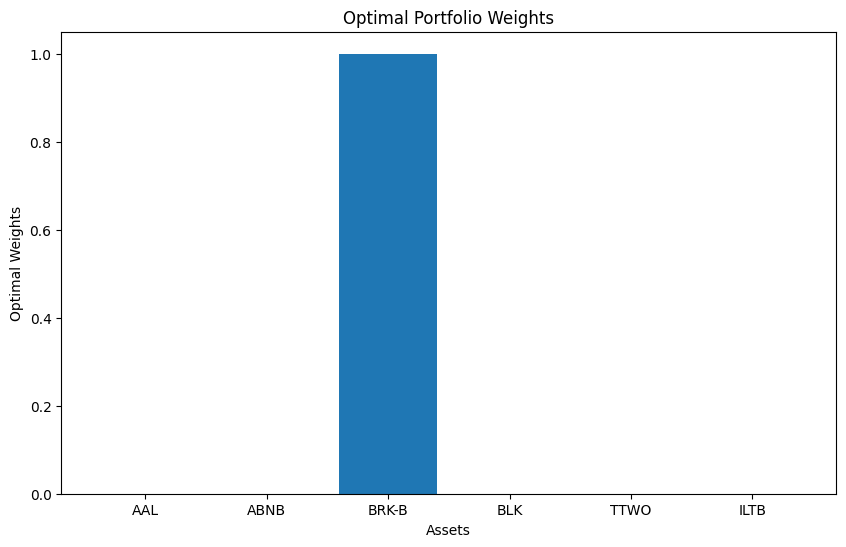

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [15]:
print(optimal_weights)

[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 5.88418203e-15 0.00000000e+00]
